# Propensity Score Evaluation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
import sys
import plotnine as p9


# Sklearn imports
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

# LightGBM import
import lightgbm as lgb

# configure logging
import logging
# Clear all existing root handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure root logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Optional: notebook-specific logger
logger = logging.getLogger("notebook")
logger.info("Notebook logger is active.")

# Add the DGP and utils modules to the path
sys.path.append('../dgps')
from dgp_01 import dgp_01

sys.path.append('../utils')
from ps_models import StackedEnsemble
from ps_evaluation import evaluate_and_rank_models, log_evaluation_report
from covariate_balance import MultiMethodBalanceTable
from ps_plots import plot_propensity_distributions, plot_calibration_curves, plot_vs_true_propensity_comparison

plt.style.use("tableau-colorblind10")
sns.set_palette("colorblind")
p9_colors = [to_hex(c) for c in sns.color_palette("colorblind")]

# Set random seed for reproducibility
np.random.seed(42)

2025-07-11 11:14:28,955 - notebook - INFO - Notebook logger is active.


## Synthetic Data

Generate synthetic data to compare the performance of different propensity score estimation methods.


In [2]:
# Generate training dataset using the DGP
n_train = 1000
n_test = 1000
treatment_coef_std = 0.5
outcome_coef_std = 10.0

dgp_dict = {
    "n_covariates": 5,
    "treatment_assignment": "nonlinear",
    "outcome_assignment": "nonlinear",
    "treatment_effect": 2.0,
    "noise_std": 1.0,
    "treatment_coef_std": 0.5,
    "outcome_coef_std": 10.0,
}

# Generate training data with linear treatment assignment
train_data = dgp_01(n=n_train, random_state=42, **dgp_dict)

logger.info(f"Training data shape: {train_data.shape}")
logger.info(f"Training data columns: {list(train_data.columns)}")

2025-07-11 11:14:28,979 - notebook - INFO - Training data shape: (1000, 8)
2025-07-11 11:14:28,979 - notebook - INFO - Training data columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'treatment', 'outcome', 'true_propensity_score']


### True Propensity Score Distribution

Visualize the distribution of true propensity scores on the test set.

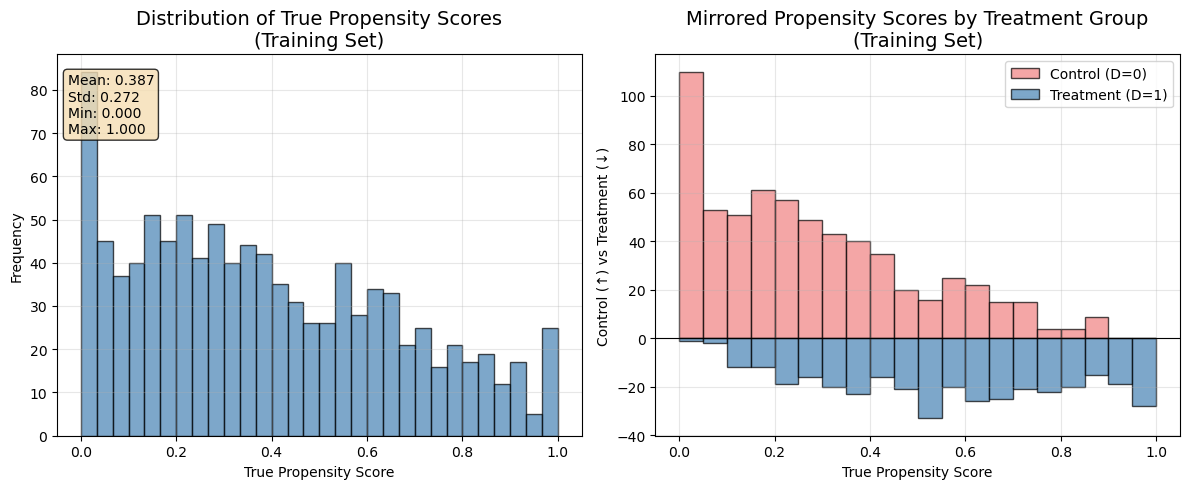

Training Set Summary:
  Total observations: 1000
  Treated: 371 (37.1%)
  Control: 629 (62.9%)
  Propensity Score - Mean: 0.387, Std: 0.272
  Propensity Score - Range: [0.000, 1.000]



In [3]:
plot_propensity_distributions(train_data, "Training")

## Propensity Scores

We will use a robust ensemble pipeline that combines multiple learners:

### Cross-fitted Propensity Scores

In [4]:
base_learners = {
    # Tree-based models
    'lgbm': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    ),
    'rf': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    
    # Linear models
    'lr': LogisticRegression(
        C=1.0,
        penalty='l2',
        random_state=42,
        max_iter=1000
    ),
}

Create and stacked learner and fit all models

In [5]:
# Create ensemble with robust scaler and logistic regression meta-learner
ensemble_model = StackedEnsemble(
    base_learners=base_learners,
    scaler=RobustScaler(),
    stacking_learner=LogisticRegression(random_state=42),
    n_folds_stacking=5
)

2025-07-11 11:14:29,238 - ps_models - INFO - StackedEnsemble initialized with 3 base learners: ['lgbm', 'rf', 'lr']
2025-07-11 11:14:29,239 - ps_models - INFO - Scaler: RobustScaler
2025-07-11 11:14:29,239 - ps_models - INFO - Stacking learner: LogisticRegression


Generate cross-fitted predictions for propensity scores.

In [6]:
ps_dict = ensemble_model.predict_ps(
    X=train_data.drop(columns=['treatment', 'true_propensity_score']),
    y=train_data['treatment']
)

2025-07-11 11:14:29,246 - ps_models - INFO - Generating propensity scores for 1000 samples using 5-fold CV
2025-07-11 11:14:35,437 - ps_models - INFO - Propensity score predictions completed for 8 models


### Predictive Performance Evaluation

In [7]:
results_df, ranking_df, summary_stats = evaluate_and_rank_models(
    y_true= train_data['treatment'],
    prob_dict=ps_dict,
    true_ps=train_data['true_propensity_score'],
    threshold=0.5,
    n_bins=10,
)

log_evaluation_report(
    results_df=results_df,
    ranking_df=ranking_df,
    summary_stats=summary_stats,
)

2025-07-11 11:14:35,493 - ps_evaluation - INFO - ================================================================================
2025-07-11 11:14:35,493 - ps_evaluation - INFO - PROPENSITY SCORE MODEL EVALUATION REPORT
2025-07-11 11:14:35,494 - ps_evaluation - INFO - ================================================================================
2025-07-11 11:14:35,494 - ps_evaluation - INFO - Dataset Summary:
2025-07-11 11:14:35,495 - ps_evaluation - INFO -   Dataset_Size: 1000
2025-07-11 11:14:35,495 - ps_evaluation - INFO -   Treatment_Rate: 0.3710
2025-07-11 11:14:35,495 - ps_evaluation - INFO -   Control_Rate: 0.6290
2025-07-11 11:14:35,495 - ps_evaluation - INFO -   N_Treated: 371
2025-07-11 11:14:35,496 - ps_evaluation - INFO -   N_Control: 629
2025-07-11 11:14:35,496 - ps_evaluation - INFO -   True_PS_Mean: 0.3874
2025-07-11 11:14:35,496 - ps_evaluation - INFO -   True_PS_Std: 0.2723
2025-07-11 11:14:35,497 - ps_evaluation - INFO -   True_PS_Min: 0.0000
2025-07-11 11:14:35,49

### Calibration Analysis

Calibration plots show how well the predicted propensity scores match the actual treatment assignment rates. A well-calibrated model should have predicted probabilities that closely match the observed frequencies.

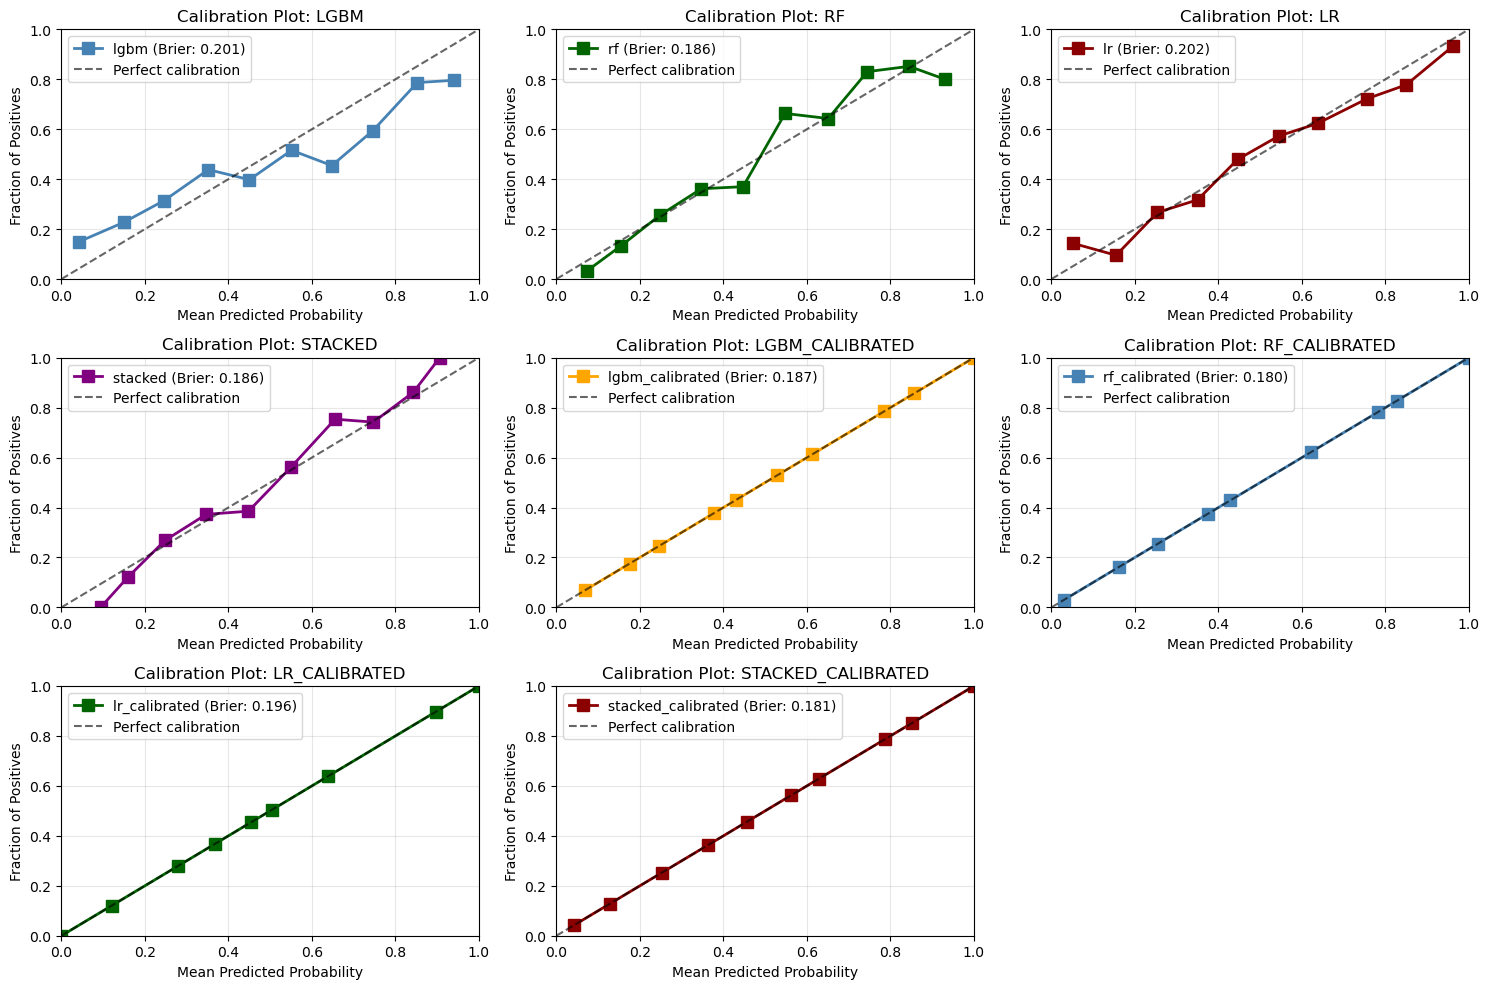

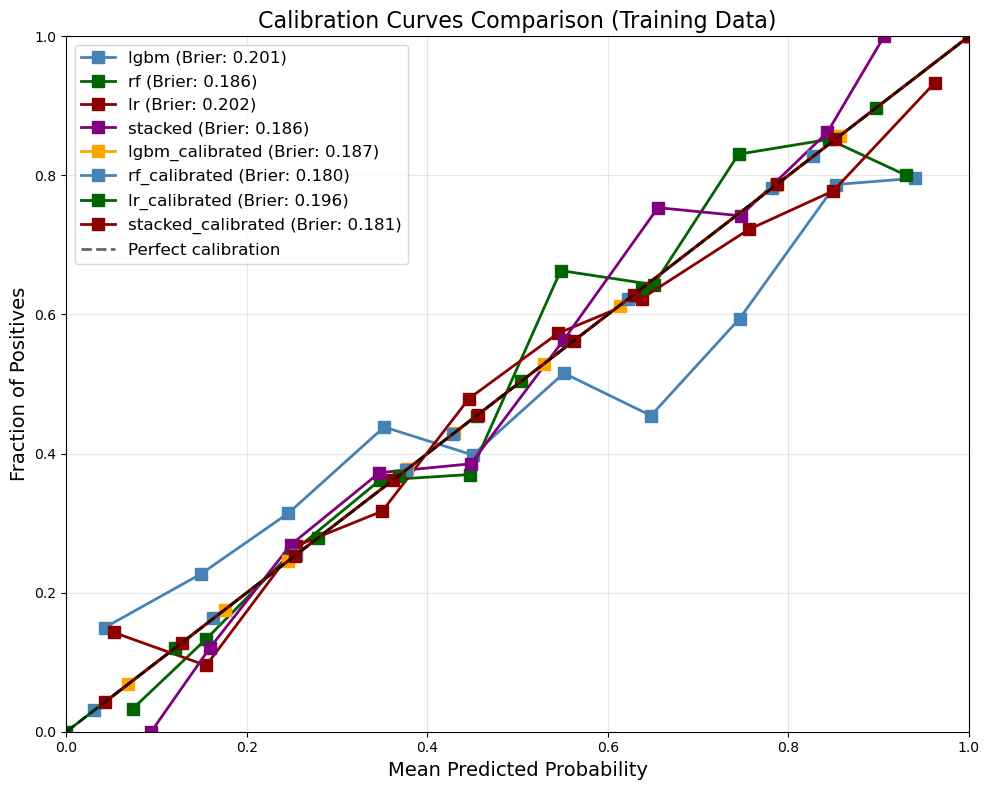

In [8]:
# Create calibration plots for training data
plot_calibration_curves(
    y_true=train_data['treatment'],
    prob_dict=ps_dict,
    n_bins=10
)

### Oracle Evaluation

Let's compare how well each model (base and calibrated) predicts the true propensity scores.

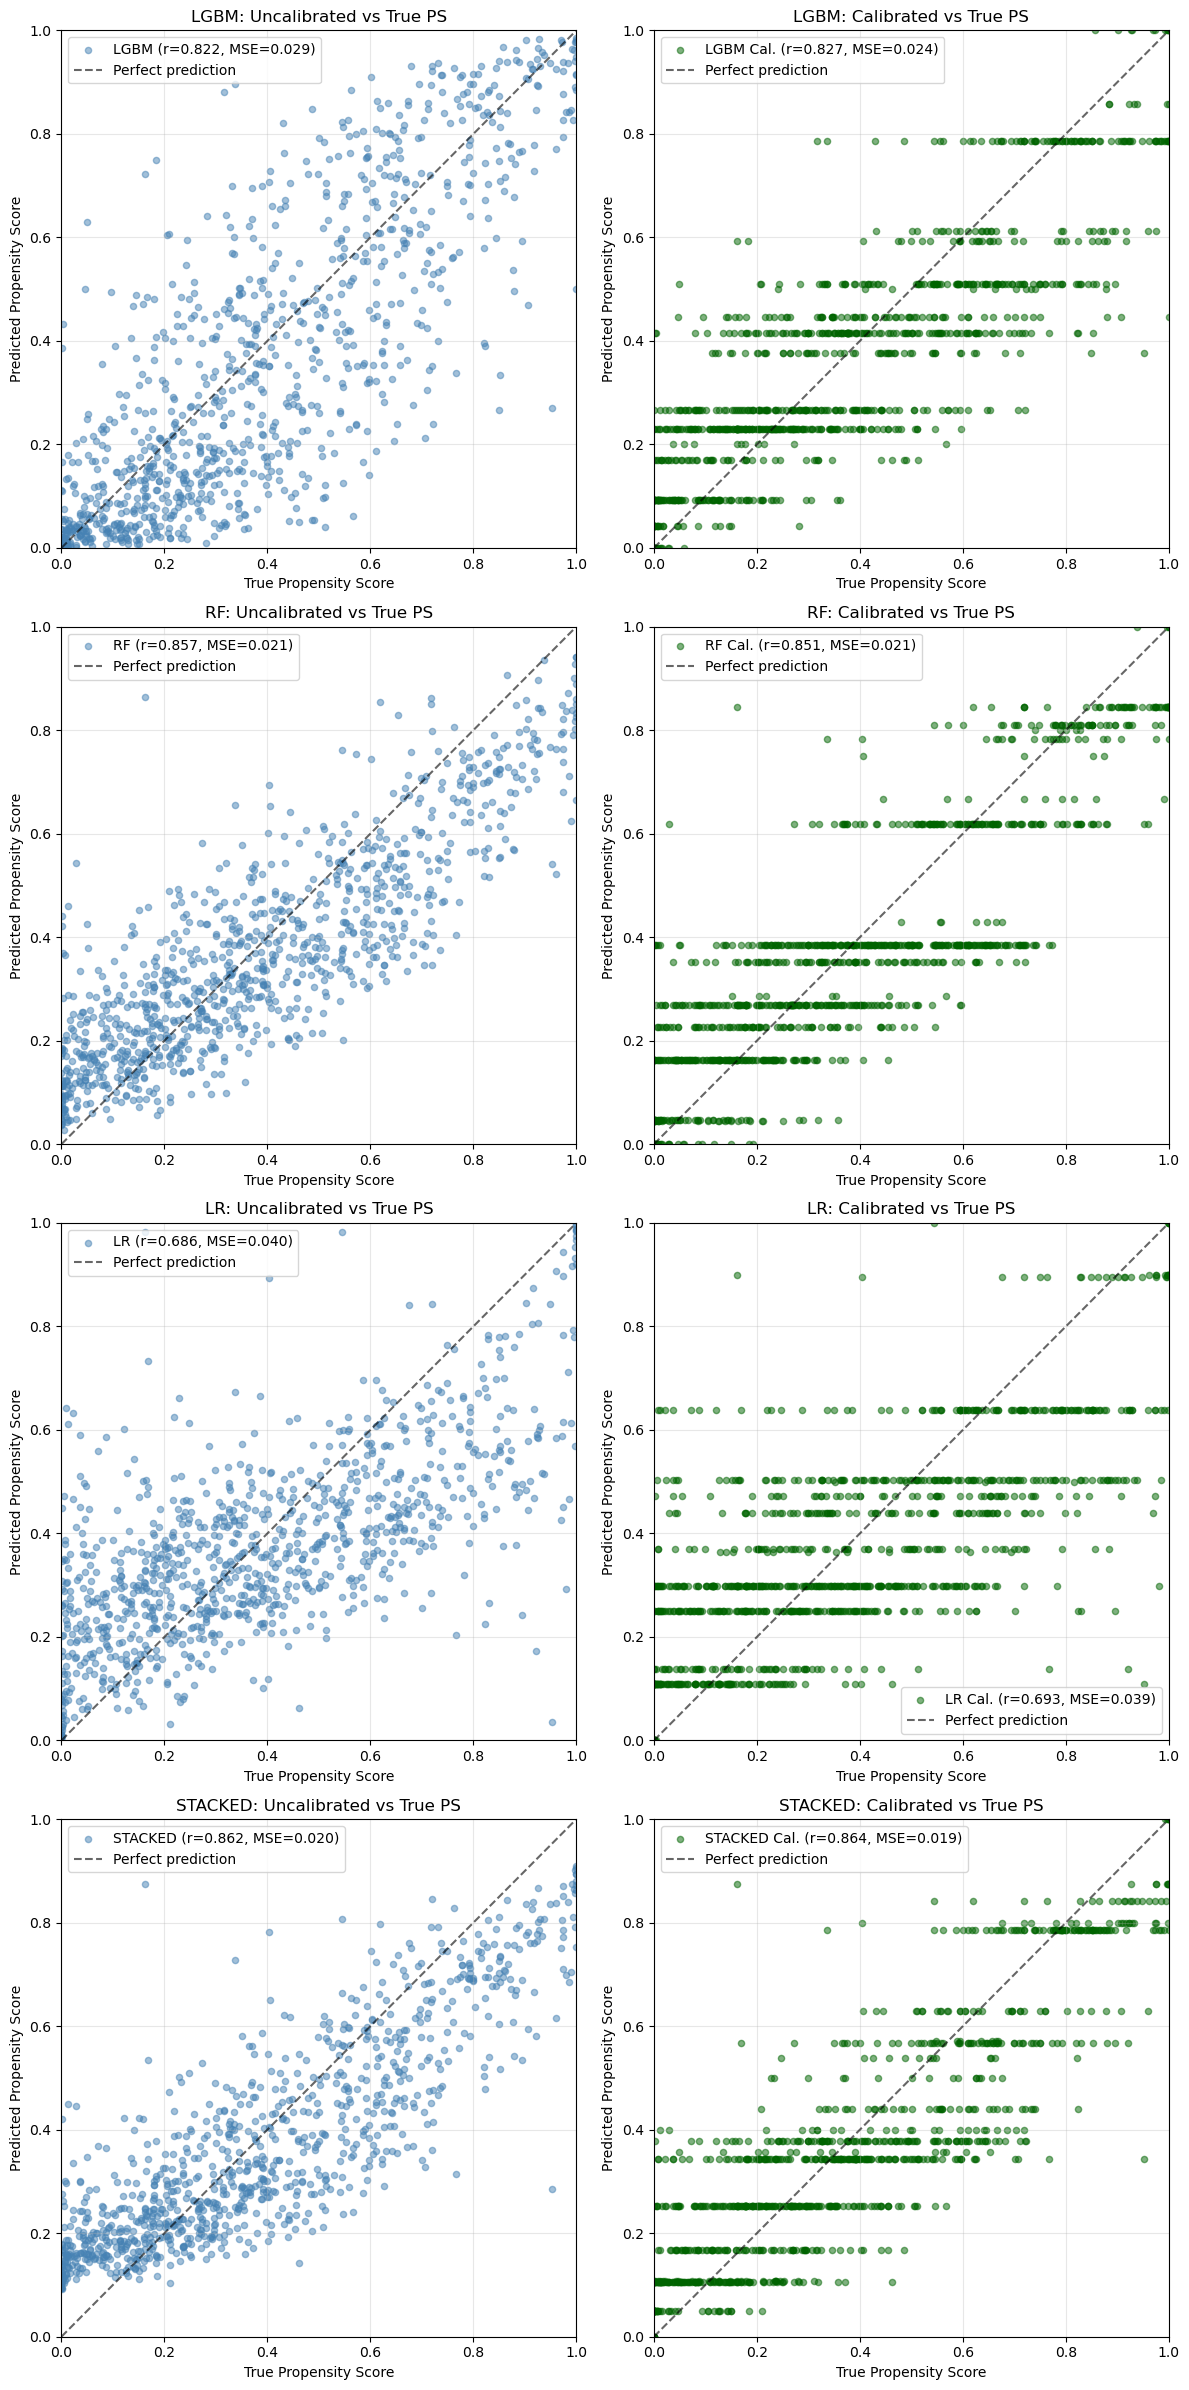

In [9]:


# Create comparison plots vs true propensity scores
plot_vs_true_propensity_comparison(
    true_ps=train_data['true_propensity_score'],
    prob_dict=ps_dict
)

## IPW & Matching Analysis

In [10]:
from covariate_balance import MultiMethodBalanceTable

ps_dict["oracle"] = train_data['true_propensity_score'].values

In [11]:
for key, value in ps_dict.items():
    logger.info(f"{key}: {len(value)} propensity scores")
    print(type(value), key, len(value))

2025-07-11 11:14:36,769 - notebook - INFO - lgbm: 1000 propensity scores
2025-07-11 11:14:36,770 - notebook - INFO - rf: 1000 propensity scores
2025-07-11 11:14:36,770 - notebook - INFO - lr: 1000 propensity scores
2025-07-11 11:14:36,770 - notebook - INFO - stacked: 1000 propensity scores
2025-07-11 11:14:36,771 - notebook - INFO - lgbm_calibrated: 1000 propensity scores
2025-07-11 11:14:36,771 - notebook - INFO - rf_calibrated: 1000 propensity scores
2025-07-11 11:14:36,771 - notebook - INFO - lr_calibrated: 1000 propensity scores
2025-07-11 11:14:36,772 - notebook - INFO - stacked_calibrated: 1000 propensity scores
2025-07-11 11:14:36,772 - notebook - INFO - oracle: 1000 propensity scores


<class 'numpy.ndarray'> lgbm 1000
<class 'numpy.ndarray'> rf 1000
<class 'numpy.ndarray'> lr 1000
<class 'numpy.ndarray'> stacked 1000
<class 'numpy.ndarray'> lgbm_calibrated 1000
<class 'numpy.ndarray'> rf_calibrated 1000
<class 'numpy.ndarray'> lr_calibrated 1000
<class 'numpy.ndarray'> stacked_calibrated 1000
<class 'numpy.ndarray'> oracle 1000


In [12]:
# Include IPW and NN matching
multi_balance = MultiMethodBalanceTable(
    df=train_data,
    cov_cols=['X1', 'X2', 'X3', 'X4', 'X5', 'treatment', 'outcome'],
    treatment='treatment',
    propensity_scores_dict=ps_dict,
    matching_methods=['ipw', 'nn_matching', 'caliper_matching']
)

# Get comparison results
comparison_df = multi_balance.get_smd_comparison()
summary_stats = multi_balance.get_balance_summary()

print("Balance Summary:")
print(summary_stats)

Balance Summary:
                                 method  mean_abs_smd_adj  max_abs_smd_adj  \
0                              lgbm_ipw          0.241157              1.0   
1                      lgbm_nn_matching          0.236943              1.0   
2                 lgbm_caliper_matching          0.236943              1.0   
3                                rf_ipw          0.212886              1.0   
4                        rf_nn_matching          0.181743              1.0   
5                   rf_caliper_matching          0.181743              1.0   
6                                lr_ipw          0.221900              1.0   
7                        lr_nn_matching          0.192486              1.0   
8                   lr_caliper_matching          0.192486              1.0   
9                           stacked_ipw          0.201529              1.0   
10                  stacked_nn_matching          0.224700              1.0   
11             stacked_caliper_matching        

2025-07-11 11:14:37,246 - matplotlib.font_manager - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


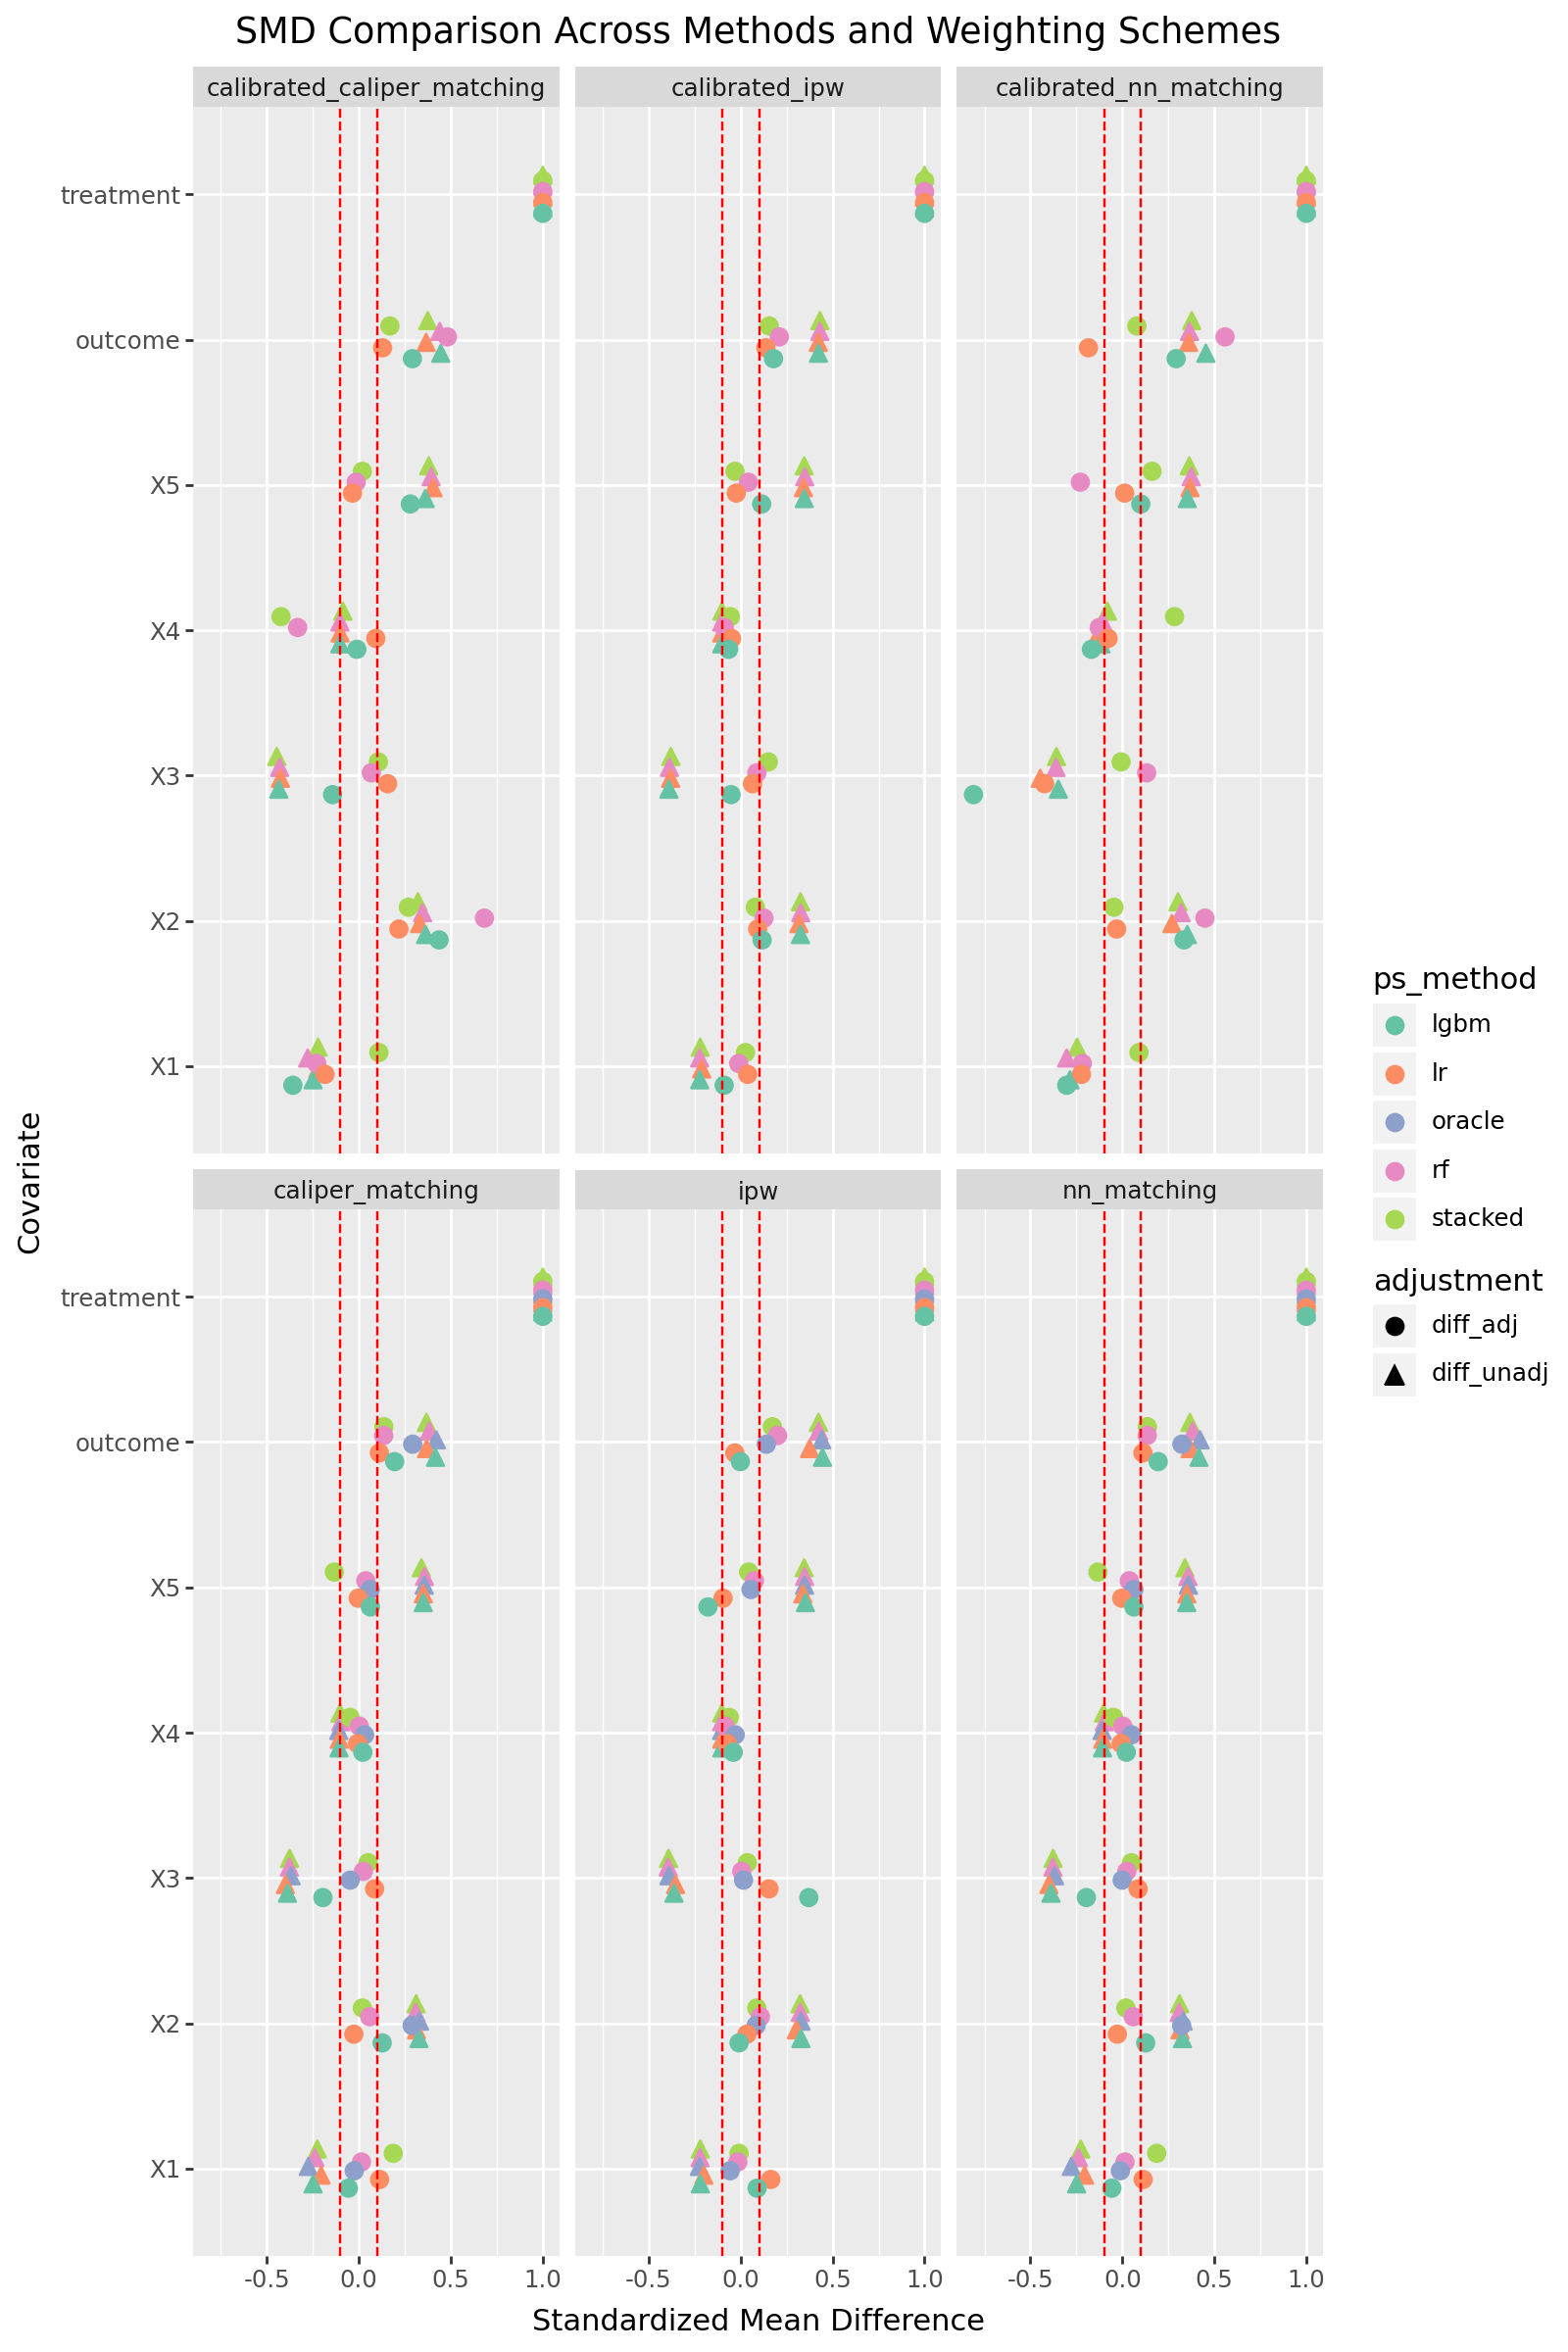

In [13]:
weighting_balance_plot = multi_balance.love_plot_comparison(facet_by='weighting_method')
weighting_balance_plot + p9.scale_color_brewer(type='qual', palette='Set2') + p9.theme(figure_size=(8, 12))

2025-07-11 11:14:37,816 - matplotlib.font_manager - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


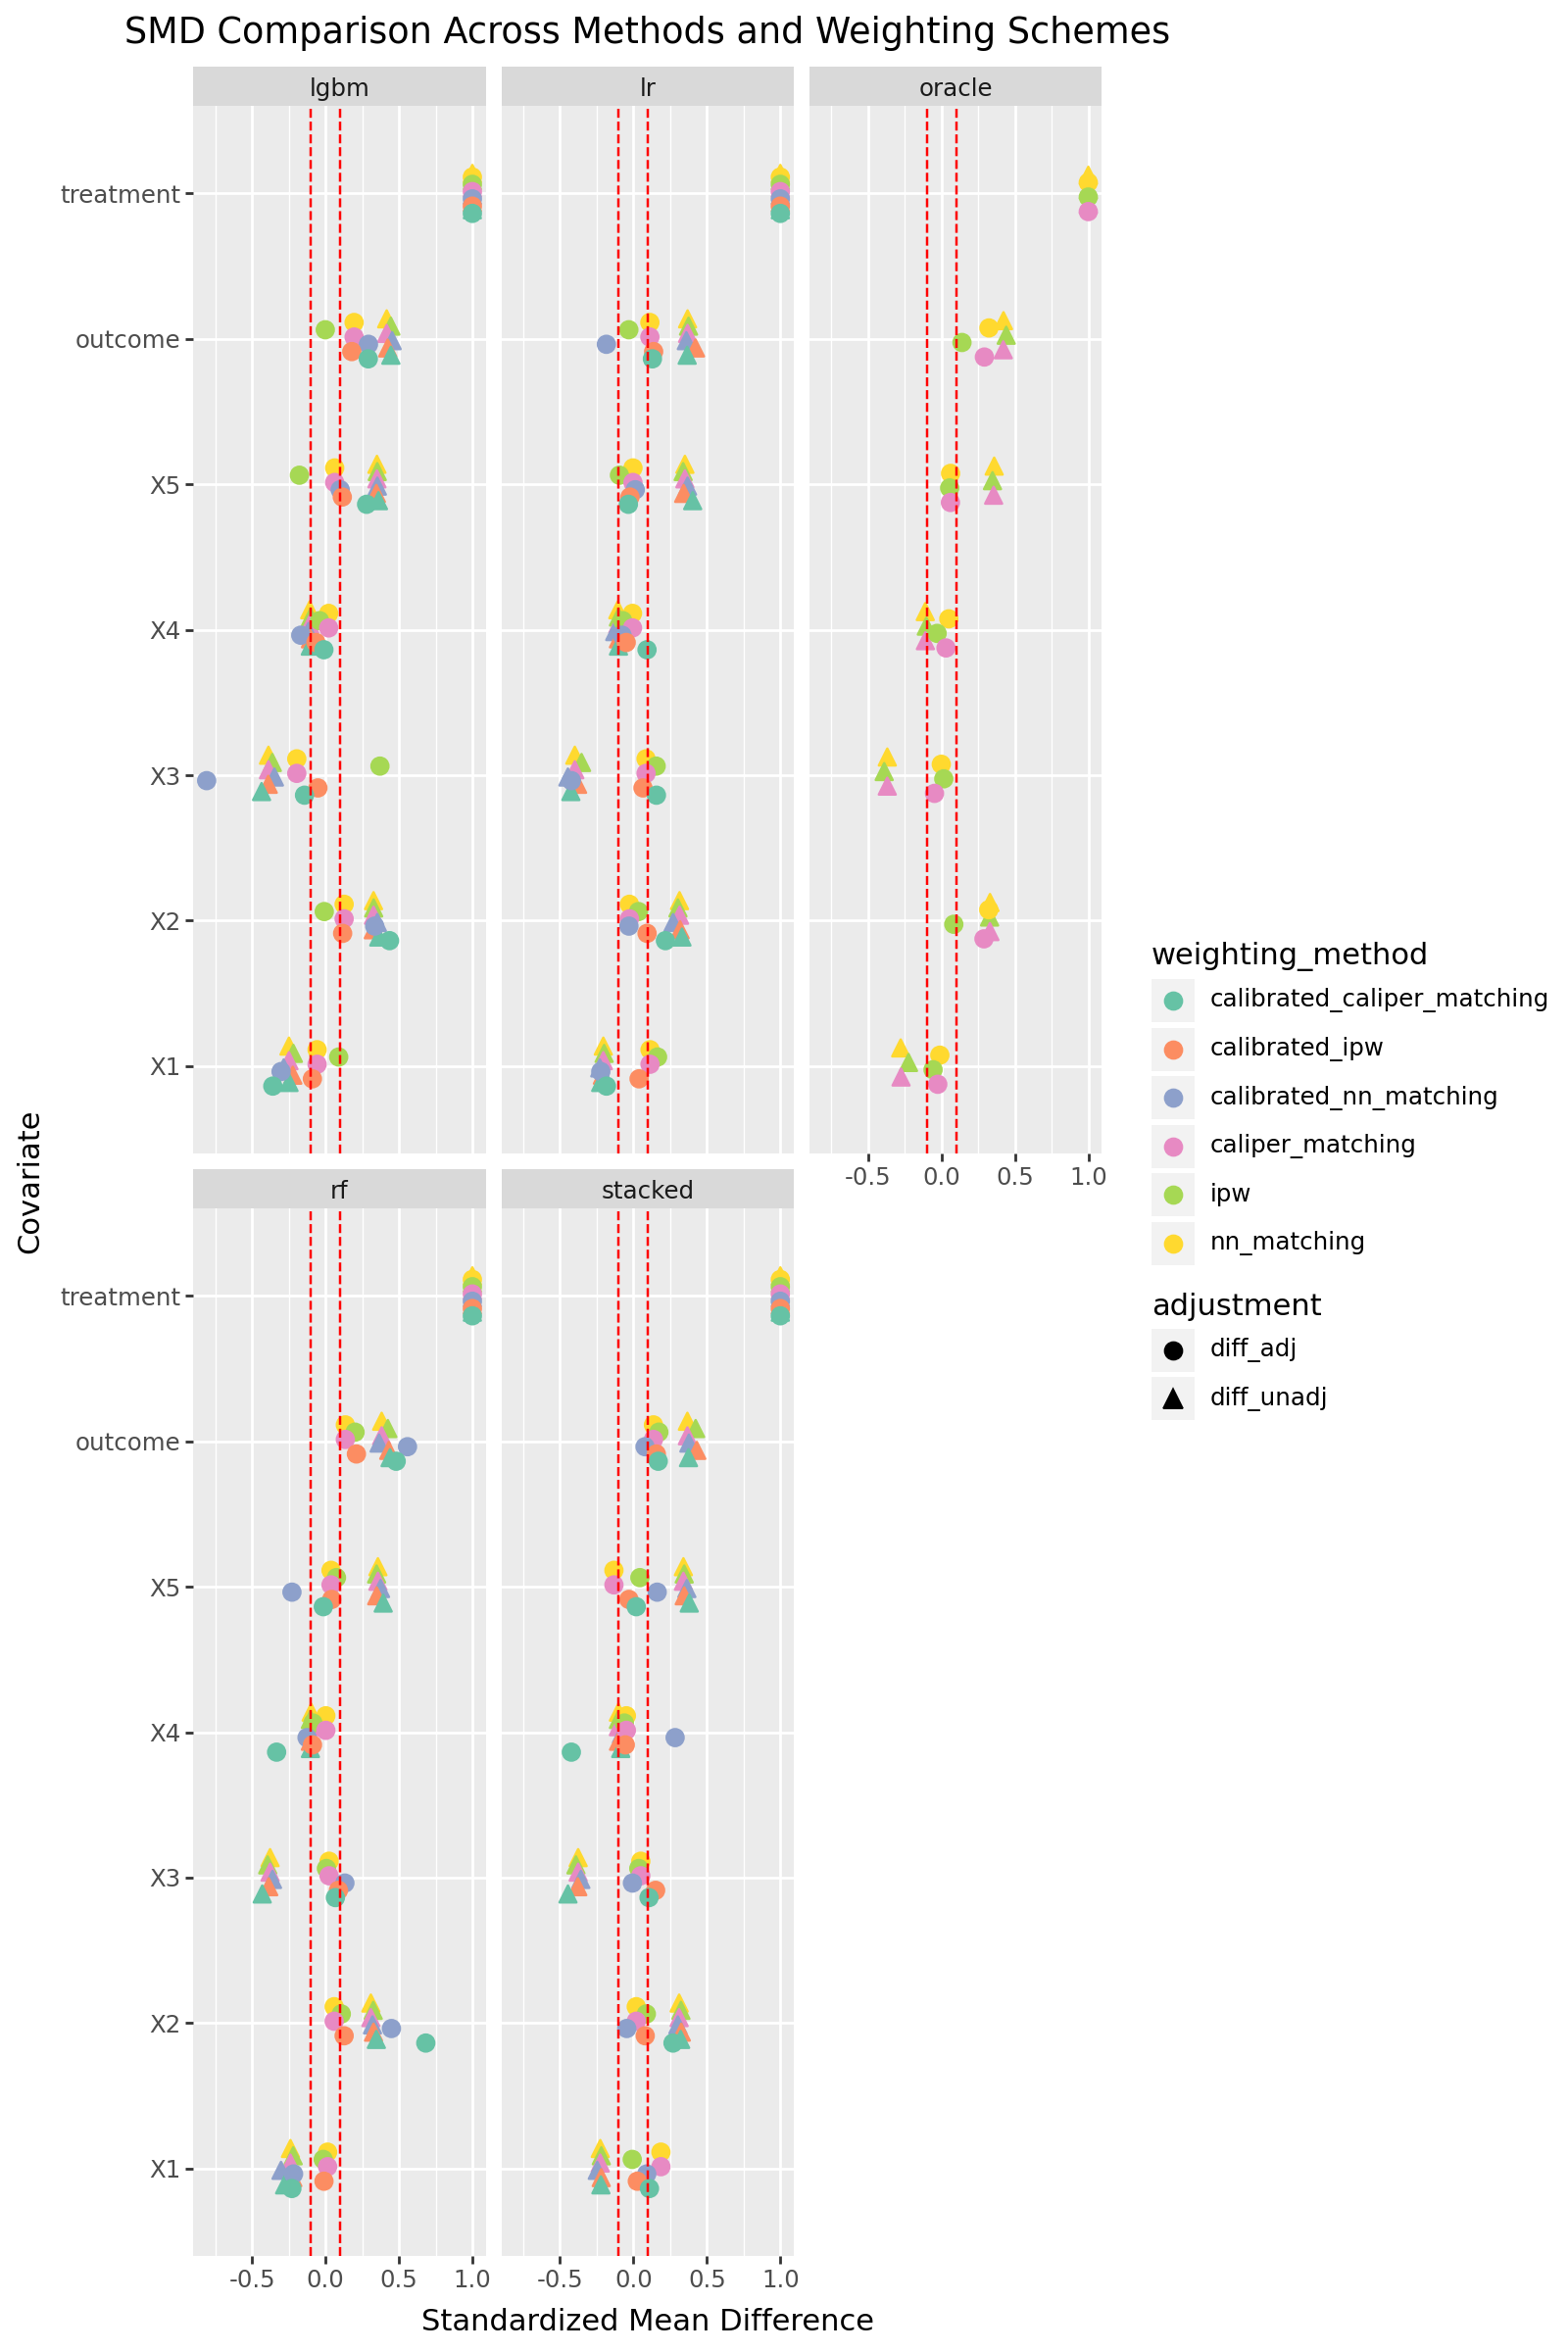

In [14]:
method_balance_plot = multi_balance.love_plot_comparison(facet_by='ps_method')
method_balance_plot + p9.scale_color_brewer(type='qual', palette='Set2') + p9.theme(figure_size=(8, 12))